# Bike-Share Demand Forecasting 1: Data Preparation

이번 timeseries forecasting 예제는 날씨에 관련성이 높은 [Capital Bikeshare scheme in 2011-12](https://www.capitalbikeshare.com/system-data)를 이용하여 bikeshare의 대여 수요를 예측하는 것입니다.

이 노트북은 UC Irvine website에서 [original weather-annotated dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)를 다운로드 받으며, S3 업로드 전에 기본적인 데이터 전처리 과정을 수행합니다.

이후 노트북에서는 S3로 업로드된 데이터셋을 이용하여 모델을 fit한 다음 정확도를 비교하게 됩니다.

### 1. Dataset 소개

 - 멤버쉽, 렌탈 및 자전거 반납 등의 프로세스가 자동으로 이루어지는 자전거 렌탈과 관련된 자전거 공유 시스템의 데이터입니다.
 - 데이터셋은 hour.csv와 day.csv를 가지고 있으며, 아래 구성 필드로 이루어져 있습니다. [단, day.csv는 hr(시간) 필드 제외]
    - instant: 기록된 index
    - dteday : 대여 날짜
    - season : 계절 데이터 (1:winter, 2:spring, 3:summer, 4:fall)
    - yr : 연도 (0: 2011, 1:2012)
    - mnth : 월 데이터 ( 1 to 12)
    - hr : 시각 (0 to 23)
    - holiday : 휴일 여부
    - weekday : 평일
    - workingday : 주중이면 1, 주말 또는 휴일이면 0
    - weathersit :
        - 1: Clear, Few clouds, Partly cloudy
        - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    - temp : Normalized 온도 (Celsius), 계산식 : (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
    - atemp: Normalized 체감 온도 (Celsius), 계산식 : (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
    - hum: Normalized 습도 (The values are divided to 100 (max))
    - windspeed: Normalized 풍속 (The values are divided to 67 (max))
    - casual: 미등록 사용자의 대여 횟수 
    - registered: 등록 사용자의 대여 횟수
    - cnt: 전체 자전거 대여 횟수 

## Dependencies and configuration<a class="anchor" id="setup"/>

라이브러리를 로딩한 다음, 설정값을 정의하고, AWS SDKs에 연결합니다.

In [34]:
install_needed = True  # should only be True once
# install_needed = False

In [35]:
%%bash
#!/bin/bash

DAEMON_PATH="/etc/docker"
MEMORY_SIZE=10G

FLAG=$(cat $DAEMON_PATH/daemon.json | jq 'has("data-root")')
# echo $FLAG

if [ "$FLAG" == true ]; then
    echo "Already revised"
else
    echo "Add data-root and default-shm-size=$MEMORY_SIZE"
    sudo cp $DAEMON_PATH/daemon.json $DAEMON_PATH/daemon.json.bak
    sudo cat $DAEMON_PATH/daemon.json.bak | jq '. += {"data-root":"/home/ec2-user/SageMaker/.container/docker","default-shm-size":"'$MEMORY_SIZE'"}' | sudo tee $DAEMON_PATH/daemon.json > /dev/null
    sudo service docker restart
    echo "Docker Restart"
fi

Already revised


In [36]:
import sys
import IPython

if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install -U 'sagemaker[local]'
    !{sys.executable} -m pip install -U sagemaker-experiments smdebug
    !{sys.executable} -m pip install -U sagemaker botocore
    !{sys.executable} -m pip install -U neuralforecast statsforecast s3fs datasetsforecast
    !{sys.executable} -m pip install -U autogluon Cython autogluon.eda
    !{sys.executable} -m pip install missingno
    IPython.Application.instance().kernel.do_shutdown(True)

installing deps and restarting kernel
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached jsonschema-3.2.0-py2.py3-none-any.whl (56 kB)
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.17.3
    Uninstalling jsonschema-4.17.3:
      Successfully uninstalled jsonschema-4.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
neuralforecast 1.5.0 requires pytorch-lightning>=2.0.0, but you have pytorch-lightning 1.9.5 which is incompatible.
neuralforecast 1.5.0 requires torch>=2.0.0, but you have torch 1.13.1 which is incompatible.
jupyterlab 3.3.4 requires jupyter-server~=1.4, but you have jupyter-server 2.0.6 which is incompatible.
jupyterlab-server 2.18.0 requires jsonschema>=4.17.3, but you have jsonschema 3.2.0 which is incompatible.
jupyter-events 0.6.0 requires jsonschema[format-non

### -----------------------------------------------------------------------------------------------

In [1]:
import sagemaker

In [2]:
sm_sess = sagemaker.session.Session()
bucket = sm_sess.default_bucket()
%store bucket

Stored 'bucket' (str)


In [3]:
%load_ext autoreload
%autoreload 1

# External Dependencies:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno
import seaborn as sn
import numpy as np

# Local Dependencies:
%aimport util

<p><img src='./BlogImages/add_img/dataset_com.png' width=700 height=600></p>



### CloudFormation으로 만들어진 S3 bucket 이름을 아래 넣습니다.
<p><img src='./BlogImages/add_img/s3bucket.png' width=700 height=500></p>

In [4]:
# Data files to be stored in S3:
data_prefix = "data/"
%store data_prefix
target_train_filename = "target_train.csv"
%store target_train_filename
target_test_filename = "target_test.csv"
%store target_test_filename
related_filename = "related.csv"
%store related_filename

Stored 'data_prefix' (str)
Stored 'target_train_filename' (str)
Stored 'target_test_filename' (str)
Stored 'related_filename' (str)


boto3 이름의 AWS SDKs python package를 이용하여 s3에 업로드 하기 위한 session을 생성합니다.

In [5]:
session = boto3.Session()
region = session.region_name
s3 = session.client(service_name="s3")

## Step 1: Fetch the source data<a class="anchor" id="fetch"/>

데이터 셋은 비교적 작은 편이기에 우르는 큰 디스크 할당 없이 노트북 인스턴스에서 데이터를 처리합니다.

In [6]:
!wget -O data.zip http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
!rm -rf ./data/raw
!mkdir -p ./data/raw
!unzip data.zip -d ./data/raw

--2023-05-16 13:16:02--  http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘data.zip’

100%[======================================>] 279,992     1.25MB/s   in 0.2s   

2023-05-16 13:16:03 (1.25 MB/s) - ‘data.zip’ saved [279992/279992]

Archive:  data.zip
  inflating: ./data/raw/Readme.txt   
  inflating: ./data/raw/day.csv      
  inflating: ./data/raw/hour.csv     


The [UCI dataset documentation](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)를 column headers 기준으로 pandas python package를 이용하여 메모리에 로드합니다.

In [7]:
raw_df = pd.read_csv(
    "./data/raw/hour.csv",
    index_col="instant",
    dtype={
        "dteday": str,
        "season": int,
        "yr": int,
        "mnth": int,
        "hr": int,
        "holiday": bool,
        "weekday": int,
        "workingday": bool,
        "weathersit": int,
        "temp": float,
        "atemp": float,
        "hum": float,
        "windspeed": float,
        "casual": int,
        "registered": int,
        "cnt": int
    }
).sort_values(["dteday", "hr"])
raw_df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,False,6,False,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,False,6,False,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,False,6,False,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,False,6,False,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,False,6,False,1,0.24,0.2879,0.75,0.0,0,1,1


추가적으로 각 컬럼들의 범위와 variation을 빠르게 확인할 수 있습니다:

In [8]:
raw_df.describe()

,season,yr,mnth,hr,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,3.003683,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,1.106918,0.500008,3.438776,6.914405,2.005771,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,1.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,3.000000,1.000000,7.000000,12.000000,3.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,5.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,4.000000,1.000000,12.000000,23.000000,6.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


## Step 2: Source Data Analysis<a class="anchor" id="fetch"/>


먼저 전체 데이터셋을 이용하여 전체 주기 동안의 수요(자전거 대여횟수)를 그래프화하여 보여줍니다.

In [9]:
hourly_df = raw_df.copy()

# Combine day and hour into datetime column, and drop superfluous date features:
hourly_df["dteday"] = pd.to_datetime(raw_df["dteday"].map(str) + " " + raw_df["hr"].map(str) + ":00")
hourly_df = hourly_df.rename(columns={ "dteday": "timestamp" }).drop(columns=["yr", "mnth", "hr"])

daterange = pd.date_range(
    start=list(hourly_df["timestamp"])[0],
    end=list(hourly_df["timestamp"])[-1],
    freq='H'
)
tmp = pd.DataFrame({ "timestamp": daterange })
tmp["dteday"] = tmp["timestamp"].dt.strftime("%Y-%m-%d")

fill_df = tmp.merge(
    hourly_df,
    how="left",
    on="timestamp"
).drop(columns=["dteday"])


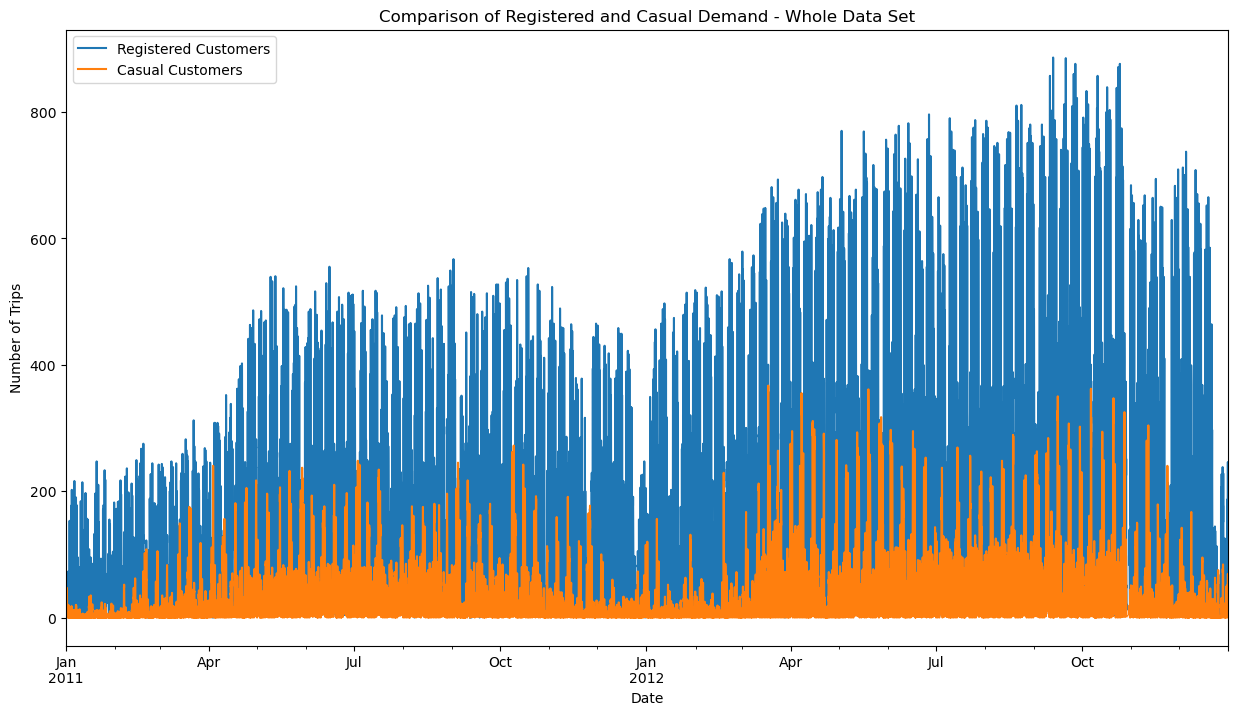

In [10]:
fig = plt.figure(figsize=(15, 8))
ax = plt.gca()
fill_df.plot(x="timestamp", y="registered", ax=ax, label="Registered Customers")
fill_df.plot(x="timestamp", y="casual", ax=ax, label="Casual Customers")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Trips")
ax.set_title("Comparison of Registered and Casual Demand - Whole Data Set")
plt.show()

위 그래프에서 우리는 아래 내용을 알 수 있습니다.

1. 등록된 고객들이 대부분의 demand를 차지합니다.
2. 비록 여름/겨울 계절성을 데이터 내에서 볼 수 있지만, 서비스의 전체 증가 및 인기도는 2년 사이 전반적으로 성장하는 것을 볼 수 있습니다.
3. 전반적인 데이터에서 볼 수 있는 것 보다 단기간 내 강한 주기성 (spikiness)가 있습니다.

** 2번은 forecast의 정확도 관점에서 어려운 상황이긴 합니다. **
- 단지 2년의 데이터만을 가지고 있으며 연간 seasonaility가 중요하지만, 일반적으로는 중요 패턴에 대해서는 5배 더 긴 주기를 가는 과거 이력이 필요합니다.
- 서비스의 전반적인 수요는 non-stationary 한 것으로 판단되며, 이는 많은 forecasting 방법에서 정확도를 떨어뜨릴 수 있습니다.[here](https://cs.nyu.edu/~mohri/talks/NIPSTutorial2016.pdf)

- 아래 그래프에서는 수요에 대해 요일과 시간의 영향이 명확히 볼 수 있으며, 적어도 여름인 8월에 casual 라이더의 경우 주 보다 주말의 여행 비율이 높다는 것을 알 수 있습니다.

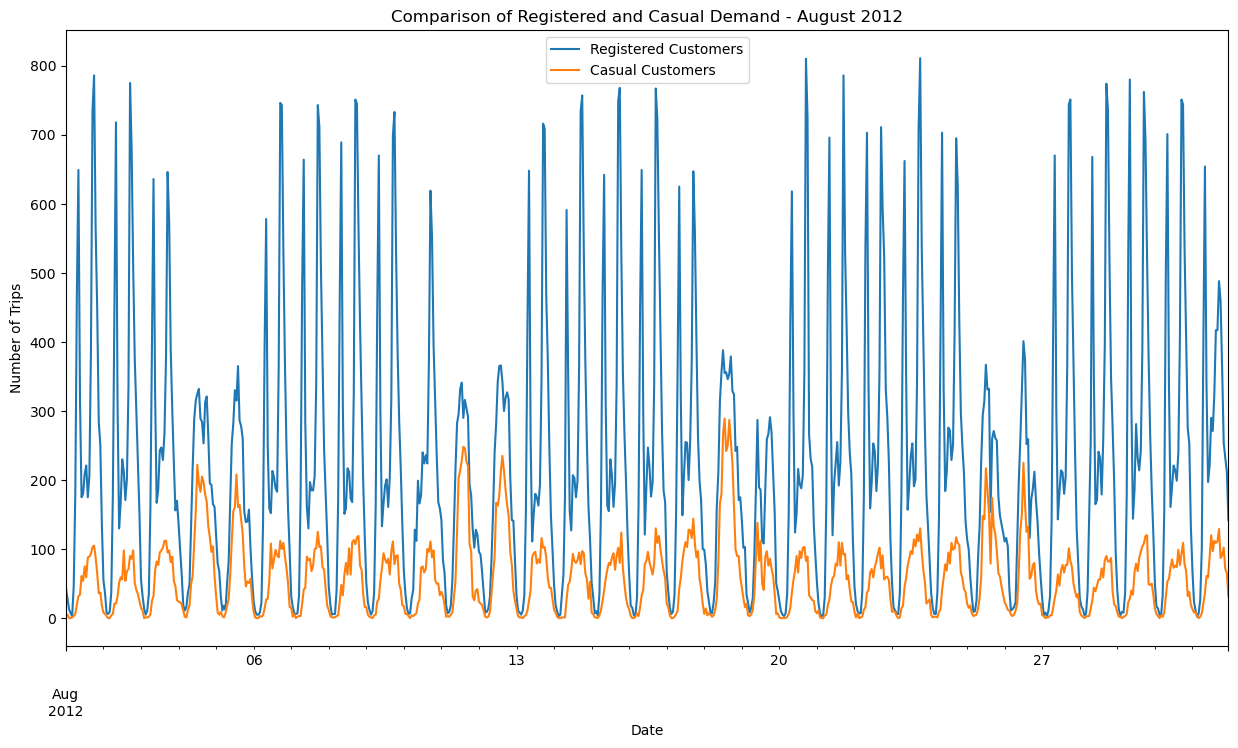

In [11]:
period_df = fill_df[(fill_df["timestamp"] >= "2012-08-01") & (fill_df["timestamp"] < "2012-09-01")]
fig = plt.figure(figsize=(15, 8))
ax = plt.gca()
period_df.plot(x="timestamp", y="registered", ax=ax, label="Registered Customers")
period_df.plot(x="timestamp", y="casual", ax=ax, label="Casual Customers")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Trips")
ax.set_title("Comparison of Registered and Casual Demand - August 2012")
plt.show()

### 1. Data Trends and Outliers Analysis

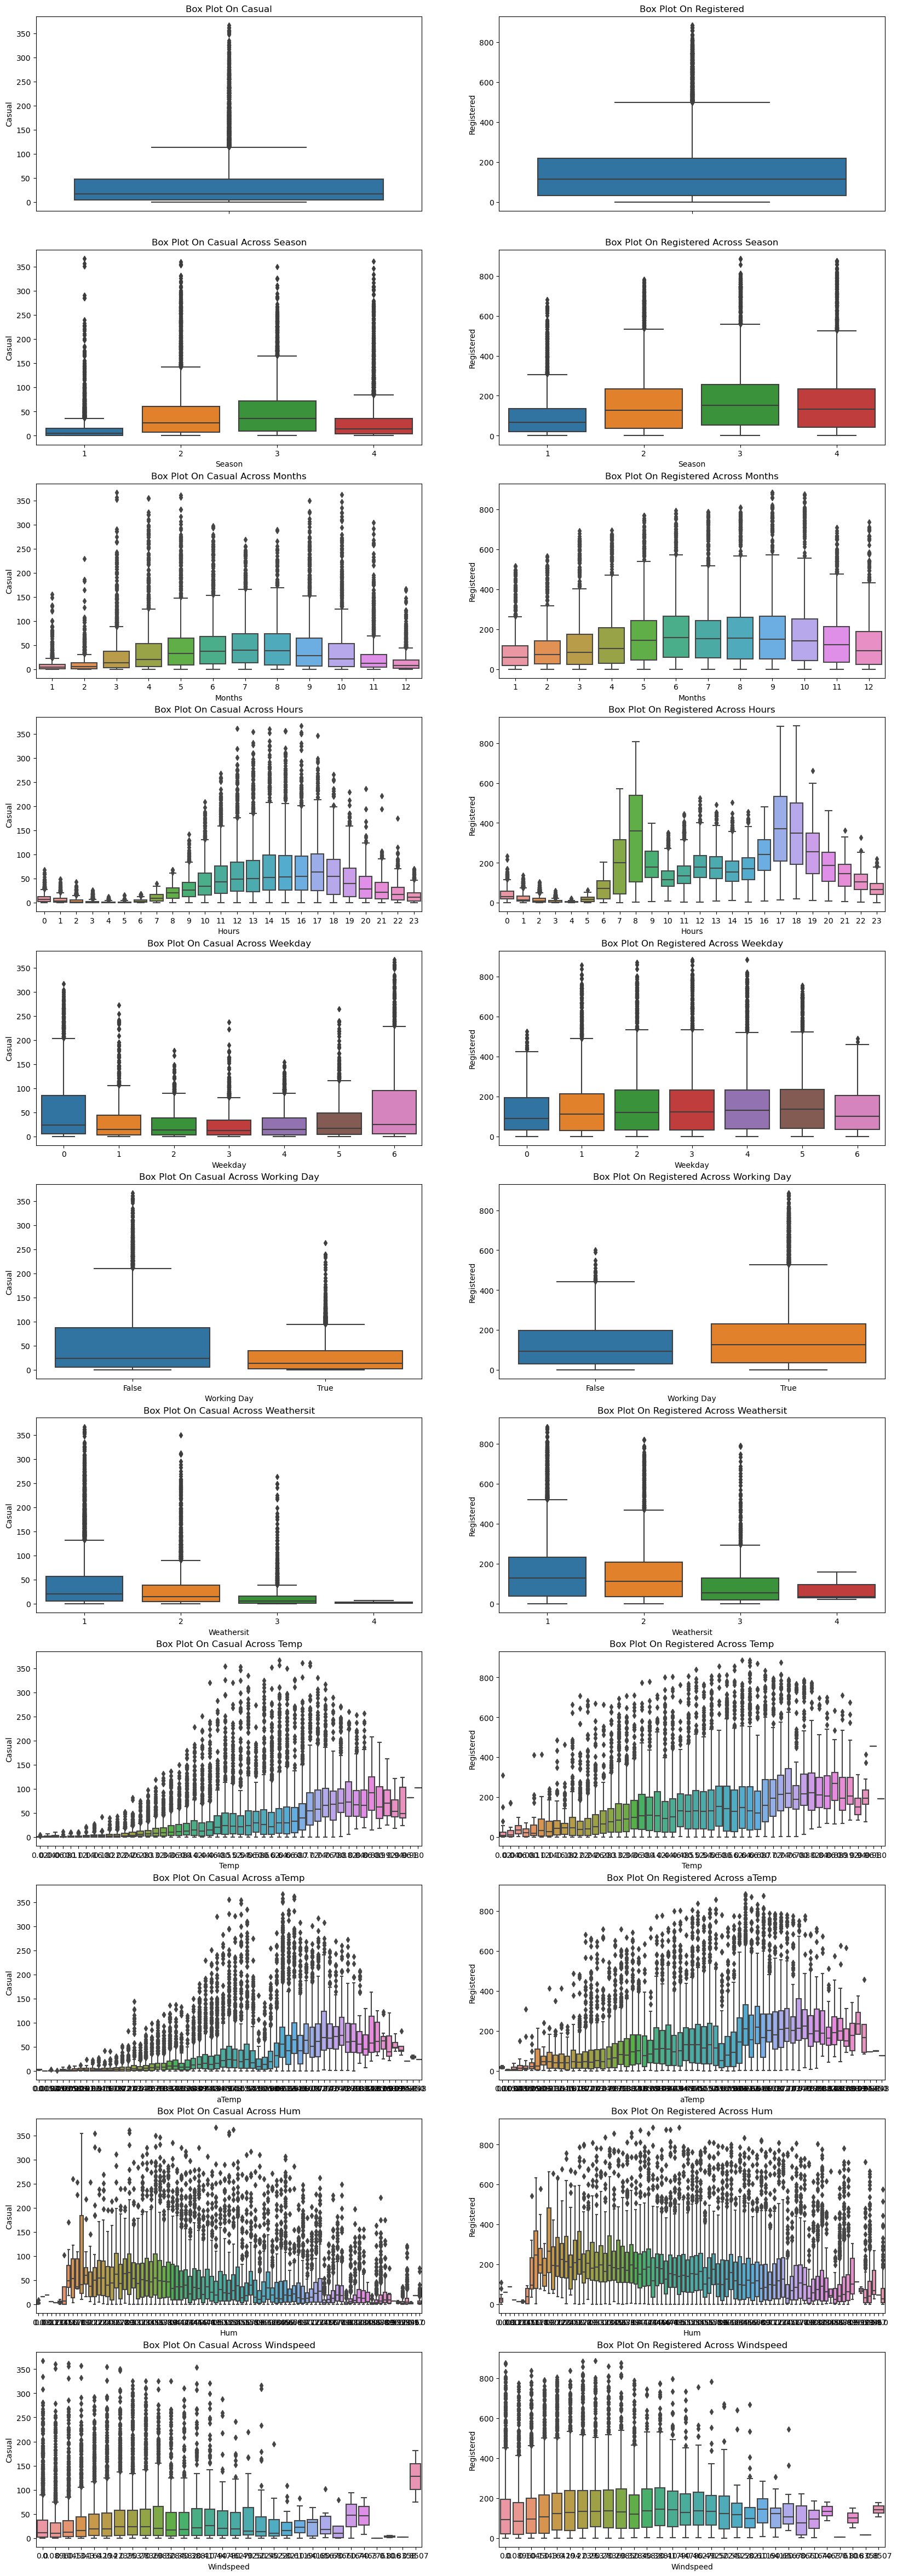

In [12]:
fig, axes = plt.subplots(nrows=11,ncols=2)
fig.set_size_inches(20, 60)
sn.boxplot(data=raw_df,y="casual",orient="v",ax=axes[0][0])
sn.boxplot(data=raw_df,y="registered",orient="v",ax=axes[0][1])

axes[0][0].set(ylabel='Casual',title="Box Plot On Casual")
axes[0][1].set(ylabel='Registered',title="Box Plot On Registered")

x_axises = ['season', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

for i, x_axis in enumerate(x_axises):
    for j, y_axis in enumerate(['casual', 'registered']):
        sn.boxplot(data=raw_df,y=y_axis,x=x_axis,orient="v",ax=axes[i+1][j])
        
x_labels = ['Season', 'Months', 'Hours', 'Weekday', 'Working Day', 'Weathersit', 'Temp', 'aTemp', 'Hum', 'Windspeed']

for i, x_label in enumerate(x_labels):
    for j, y_label in enumerate(['Casual', 'Registered']):
        title = "Box Plot On " + y_label + " Across " + x_label
        axes[i+1][j].set(xlabel=x_label, ylabel=y_label, title=title)

### 2. Missing Values Analysis

<AxesSubplot:>

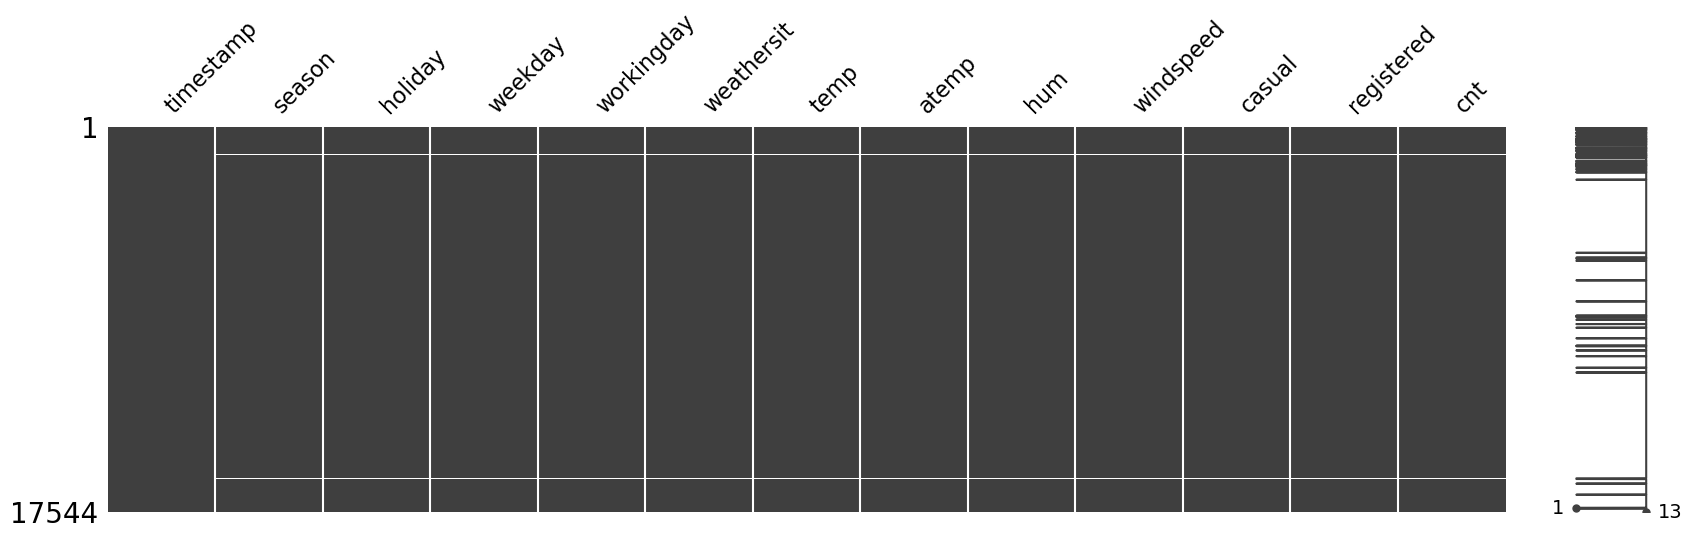

In [13]:
msno.matrix(fill_df,figsize=(20,5))

### 3. Correlation Analysis

각 feature 대비 종속 변수가 어떻게 영향을 받는지 확인하기 위해 아래 상관 행렬을 만들어 봅니다.

   - 종속변수 ```cnt``` 대비하여 ```temp/atemp```는 양의 상관관계를 가지며, ```hum```은 음의 상관관계를 갖는 것을 확인할 수 있습니다.
   - ```windspeed```는 상관성이 낮은 것으로 판단됩니다.
   - ```atemp```는 ```temp```와 상호 높은 상관 관계를 가지므로 둘 중 하나의 데이터는 삭제하는 것이 좋습니다.  
     *multicollinearity 문제 : 독립변수 간의 상관관계가 발생할 경우 삭제하는 것이 좋음*
   - ```casual```과 ```registered```는 종속변수 ```cnt```를 분리한 값이므로 이후 모델링 시에는 삭제합니다.

<AxesSubplot:>

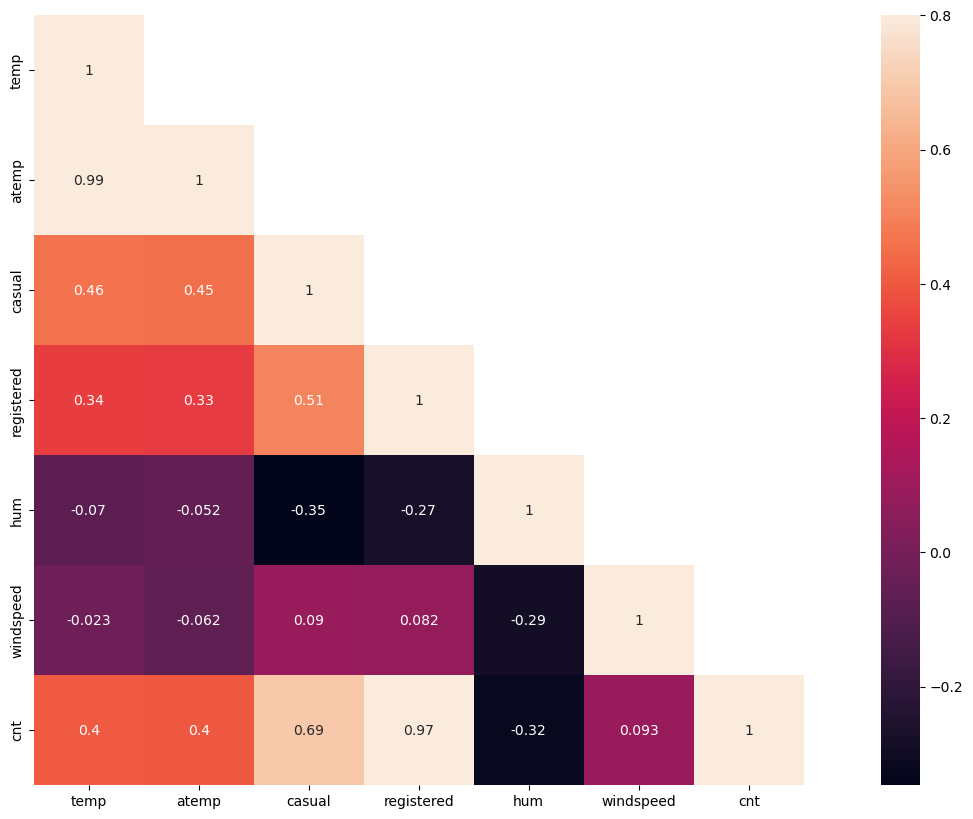

In [14]:
corrMatt = fill_df[["temp","atemp","casual","registered","hum","windspeed","cnt"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

## Step 3: Load data & interpolate gaps<a class="anchor" id="convert"/>

The raw dataset has:

* 날짜 / 시간 열 중복 제거 필요
* 대여 횟수가 없는 시간은 raw dataset에서 나타나지 않음

...which we'll deal with here, starting with the timestamp tidy-up:

In [15]:
hourly_df = raw_df.copy()

# Combine day and hour into datetime column, and drop superfluous date features:
hourly_df["dteday"] = pd.to_datetime(raw_df["dteday"].map(str) + " " + raw_df["hr"].map(str) + ":00")
hourly_df = hourly_df.rename(columns={ "dteday": "timestamp" }).drop(columns=["yr", "mnth", "hr"])

아무도 자전거를 사용하지 않은 시간 동안 행은 누락되었지만 적용 범위 내 매일 최소 하나의 행은 존재합니다.
결측치는 아래와 같이 처리하였습니다.

 1. 라이더 수 (casual, registered, cnt) 는 0으로 설정 (cnt=0 은 행 대체가 적용된 경우 복구 시 사용)
 2. 일별 값 (season, holiday, weekday, workingday)은 해당 날짜의 원본 레코드의 평균값을 사용
 3. 날씨 데이터 (weathersit, temp, atemp, hum, windspeed): 시간 상 현재 레코드들과 가장 근접한 값들로 보간하여 사용

In [16]:
# Compare the full range of hours covered by the data-set, to the number of records:
daterange = pd.date_range(
    start=list(hourly_df["timestamp"])[0],
    end=list(hourly_df["timestamp"])[-1],
    freq='H'
)

n_raw_records = len(hourly_df)
n_range_hours = len(daterange)
print(f"{n_raw_records} raw records vs {n_range_hours} hours in date range")
if (n_raw_records == n_range_hours):
    print("Data fully specified")
elif (n_raw_records < n_range_hours):
    # (We expect to see this)
    print("MISMATCH: Missing data will be interpolated")
elif (n_raw_records > n_range_hours):
    raise NotImplementedError("This script can't deal with duplicates yet!")

# Construct a fully range-covering table
# (including day-granularity fields taken from aggregating the source table)
tmp = pd.DataFrame({ "timestamp": daterange })
tmp["dteday"] = tmp["timestamp"].dt.strftime("%Y-%m-%d")
fill_df = tmp.merge(
    raw_df.groupby("dteday").agg("mean")[["season", "holiday", "weekday", "workingday"]],
    how="left",
    on="dteday"
).drop(columns=["dteday"])

# Join the whole-range table to our target, and fill in the day-granularity fields
assert (
    hourly_df.isna().sum().sum() == 0
), "These imputations assume no missing values in source data set records!"

imputed_df = fill_df.merge(hourly_df, how="left", on="timestamp", suffixes=("_day", ""))
imputed_df["season"].fillna(imputed_df["season_day"], inplace=True)
imputed_df["holiday"].fillna(imputed_df["holiday_day"], inplace=True)
imputed_df["weekday"].fillna(imputed_df["weekday_day"], inplace=True)
imputed_df["workingday"].fillna(imputed_df["workingday_day"], inplace=True)
imputed_df.drop(columns=["season_day", "holiday_day", "weekday_day", "workingday_day"], inplace=True)


# Convert boolean value to float
imputed_df["holiday"] = imputed_df["holiday"].astype(float)
imputed_df["workingday"] = imputed_df["workingday"].astype(float)

# Fill all missing demand values with zero (which is why the records were missing in the first place)
imputed_df["casual"].fillna(0, inplace=True)
imputed_df["registered"].fillna(0, inplace=True)
imputed_df["cnt"].fillna(0, inplace=True)

# Interpolate over time for missing weather data fields:
imputed_df = imputed_df.set_index("timestamp")
imputed_df["weathersit"] = imputed_df["weathersit"].interpolate(method="time").round()
imputed_df["temp"].interpolate(method="time", inplace=True)
imputed_df["atemp"].interpolate(method="time", inplace=True)
imputed_df["hum"].interpolate(method="time", inplace=True)
imputed_df["windspeed"].interpolate(method="time", inplace=True)
imputed_df = imputed_df.reset_index()

assert not imputed_df.isna().any().any(), "Imputed DF should not have any remaining nulls!"
assert len(imputed_df) == n_range_hours, "Imputed DF should fully cover time range!"

print("Imputation complete")
imputed_df.head()

17379 raw records vs 17544 hours in date range
MISMATCH: Missing data will be interpolated
Imputation complete


,timestamp,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01 00:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,0.0,1.0,1.0


In [17]:
# Feel free to extend feature engineering here, just leaving timestamp and *_demand columns alone:
target_suffix = "_demand"
full_df = imputed_df.rename(columns={
    "casual": f"casual{target_suffix}",
    "registered": f"registered{target_suffix}",
    "cnt": f"total{target_suffix}"
})

full_df.head()

,timestamp,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual_demand,registered_demand,total_demand
0,2011-01-01 00:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,0.0,1.0,1.0


## Step 4: Train/test split for eodel evaluation<a class="anchor" id="split"/>

feature engineering 작업을 수행한 다음, 고민해야 할 가장 중요한 의문점은 모델의 정확도를 평가하는 방법입니다.

### How to evaluate forecast models

forecasting 알고리즘을 평가하는 것과 일반적인 ML 방법과의 중요한 차이는 **casuality (인과관계)** 입니다. 과거 데이터 기반으로 우리의 모델을 fitting 해야 합니다. 그리고, 알 수 없는 "미래" 데이터를 평가합니다. 모델의 fitting 프로세스에서는 미래의 데이터가 보이지 않도록 합니다.

**[Backtesting](https://en.wikipedia.org/wiki/Backtesting)** (or "hindcasting")는 이런 인과관계를 평가하는 프로세스입니다. 과거 데이터에서 시점 기준으로 하나 이상의 포인트를 선택하는 방법으로 cut-off 시나리오에서 사용합니다. 포인트 이전 데이터는 학습 데이터로 사용하고, 이후 데이터는 평가용으로 사용합니다.  

<img src="BlogImages/backtest.png"/>

다중의 timeseries를 갖는 상황에서, Target Timeseries와 Related Timeseries의 차이점을 아래 그림으로 알 수 있습니다.

* **target timeseries** (모델이 예측하고자 하는 값들), and
* **[related timeseries](https://docs.aws.amazon.com/forecast/latest/dg/related-time-series-datasets.html)** (예측 기간에 대해 우리가 미리 알 수 있는 값들)

따라서, target timeseries에 대해서만 train/test split을 수행합니다.


<img src="BlogImages/rts_viz.png">


### Choosing the Setup for our Bike Forecasting example

소스 데이터는 **hourly granularity**를 가지고 있으며, 이는 예측 가능한 단위의 가장 하한 값입니다.
이 granularity를 사용하거나, 또는 aggregate up할지를 선택하여 적절한 **forecast horizon**가 무엇인지를 가이드할 것입니다.

* 모델 학습은 주어진 forecast horizon에 대해 전체 정확도를 최적화할 것입니다. 따라서, 대부분의 유용한 horizon은 **비즈니스 문제**에 따라 선정해야 합니다. 예를 들어, 최선을 다해 1년을 예측하는 모델을 학습했다고 하지만, 실제 1개월 계획을 세우기 위해 사용하는 경우에는 성능이 떨어질 수 있습니다.
* DeepAR과 같은 RNN (Recurrent Neural Models)과도 비교할 것이기 때문에, granularity가 적어도 forecast window의 특정 비율일 때 이 아키텍처들의 일부에서 나쁘게 작동한다는 점도 고려할 필요가 있습니다. 어떤 패턴의 주기를 학습 할 수 있는지에 대한 제약 사항은 샘플 주기에 비례합니다. 특히, Amazon Forecast는 최대 500개의 샘플 forecast horizon까지 가능합니다. [limit](https://docs.aws.amazon.com/forecast/latest/dg/limits.html)
* 알고리즘은 context window 내 데이터가 거의 **stationary**하고 가장 긴 fluctuations의 여러 사이클을 잡아낼 때 최상으로 수행될 것입니다. 분기 또는 연간 forecasts는 사용 가능한 데이터셋에 대해 적합하지 않을 수 있습니다.

또한,

* (적어도 일부 국가에서) 괜찮은 날씨 예측이 가능한 기간과 수요에 적합하도록 bikes의 이동 및 배치를 위해, 적합한 사전 planning 단계를 수행할 수 있는 기간으로 설정합니다. 이번 예시에서는 **14일 (2주) horizon**에 대한 predictors를 학습할 것입니다.

연말 기간이 business 적으로 중요한 시간임으로 가정하여, 2012-12-01 까지를 최종 테스트 cutoff로 offset합니다. final evaluation window는 단지 2년의 데이터를 제공하는 상황이기 때문에 모델에 대해 연간 seasonality의 노출을 최대화합니다.

<img src='BlogImages/add_img/dataset.png' width=900 height=700>

In [18]:
cutoff_test_start = "2012-12-01"

full_headers = full_df.columns.to_list()
timestamp_header = "timestamp"
target_headers = list(filter(lambda s: s.endswith(target_suffix), full_headers))
target_nontotal_headers = list(filter(lambda s: s != "total_demand", target_headers))
related_headers = list(filter(lambda s: (s not in target_headers) and (s != timestamp_header), full_headers))

In [19]:
# Unpivoted dataframe of target variables, still sorted by timestamp:
target_full_df = full_df[[timestamp_header] + target_nontotal_headers].melt(
    id_vars=[timestamp_header],
    value_vars=target_nontotal_headers,
    var_name="customer_type",
    value_name="demand"
).sort_values(by=[timestamp_header, "customer_type"]).reset_index(drop=True)

# Strip "_demand" from the target IDs:
target_full_df["customer_type"] = target_full_df["customer_type"].apply(lambda s: s[0:-len(target_suffix)])

target_full_df.head()

,timestamp,customer_type,demand
0,2011-01-01 00:00:00,casual,3.0
1,2011-01-01 00:00:00,registered,13.0
2,2011-01-01 01:00:00,casual,8.0
3,2011-01-01 01:00:00,registered,32.0
4,2011-01-01 02:00:00,casual,5.0


In [20]:
target_train_df = target_full_df[target_full_df[timestamp_header] < cutoff_test_start]
target_test_df = target_full_df[target_full_df[timestamp_header] >= cutoff_test_start]

related_df = full_df[[timestamp_header] + related_headers]

print(f"{len(target_train_df)} target training points")
print(f"{len(target_test_df)} target test points")
print(f"{len(related_df)} related timeseries points")

related_df.head()

33600 target training points
1488 target test points
17544 related timeseries points


,timestamp,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01 00:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0
1,2011-01-01 01:00:00,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0
2,2011-01-01 02:00:00,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0
3,2011-01-01 03:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0
4,2011-01-01 04:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0


In [21]:
print("Writing dataframes to file...")
target_train_df.to_csv(
    f"./data/{target_train_filename}",
    index=False
)
target_test_df.to_csv(
    f"./data/{target_test_filename}",
    index=False
)
related_df.to_csv(
    f"./data/{related_filename}",
    index=False
)

print("Uploading dataframes to S3...")
s3.upload_file(
    Filename=f"./data/{target_train_filename}",
    Bucket=bucket,
    Key=f"{data_prefix}{target_train_filename}"
)
s3.upload_file(
    Filename=f"./data/{target_test_filename}",
    Bucket=bucket,
    Key=f"{data_prefix}{target_test_filename}"
)
s3.upload_file(
    Filename=f"./data/{related_filename}",
    Bucket=bucket,
    Key=f"{data_prefix}{related_filename}"
)
print("Done")


Writing dataframes to file...
Uploading dataframes to S3...
Done


In [31]:
target_train_df.rename(columns={ "customer_type": "item_id" }, inplace=True)
target_test_df.rename(columns={ "customer_type": "item_id" }, inplace=True)
target_train_df.head()

/tmp/ipykernel_8979/1052623373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_train_df.rename(columns={ "customer_type": "item_id" }, inplace=True)
/tmp/ipykernel_8979/1052623373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_test_df.rename(columns={ "customer_type": "item_id" }, inplace=True)


,timestamp,item_id,demand
0,2011-01-01 00:00:00,casual,3.0
1,2011-01-01 00:00:00,registered,13.0
2,2011-01-01 01:00:00,casual,8.0
3,2011-01-01 01:00:00,registered,32.0
4,2011-01-01 02:00:00,casual,5.0


In [60]:
# Duplicate data for each item_id in the target dataframe:
related_peritem_dfs = []
item_ids = target_train_df["item_id"].unique()
for item_id in item_ids:
    df = related_df.copy()
    df["item_id"] = item_id
    related_peritem_dfs.append(df)

related_df = pd.concat(related_peritem_dfs).sort_values(["timestamp", "item_id"]).reset_index(drop=True)

# Rename any reserved columns to keep Forecast happy:
related_df.rename(columns={ "temp": "temperature" }, inplace=True)
related_df.head()

,timestamp,season,holiday,weekday,workingday,weathersit,temperature,atemp,hum,windspeed,item_id
0,2011-01-01,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,casual
1,2011-01-01,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,casual
2,2011-01-01,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,casual
3,2011-01-01,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,casual
4,2011-01-01,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,casual


In [61]:
train_df = pd.merge(target_train_df, related_df, on=['timestamp', 'item_id'], how='left')
test_df = pd.merge(target_test_df, related_df, on=['timestamp', 'item_id'], how='left')

In [65]:
# train_data = train_df.drop(columns='timestamp')
# test_data = test_df.drop(columns='timestamp')

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/autogluon/eda/analysis/dataset.py:239: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  summary = df.describe(include="all").T
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/autogluon/eda/analysis/dataset.py:239: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  summary = df.describe(include="all").T


**`train_data` dataset summary**

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,special_types
atemp,268800,177,,,NaT,NaT,0.480671,0.172321,0.0,0.3333,0.5,0.6212,1.0,float64,,,float,
demand,268800,774,,,NaT,NaT,94.314464,126.814569,0.0,9.0,43.0,134.0,886.0,float64,,,float,
holiday,268800,2,,,NaT,NaT,0.028571,0.166599,0.0,0.0,0.0,0.0,1.0,float64,,,float,
hum,268800,189,,,NaT,NaT,0.626008,0.19335,0.0,0.47,0.63,0.78,1.0,float64,,,float,
item_id,268800,2,casual,134400,NaT,NaT,,,,,,,,object,,,object,
season,268800,4,,,NaT,NaT,2.477143,1.089323,1.0,2.0,2.0,3.0,4.0,float64,,,float,
temperature,268800,166,,,NaT,NaT,0.502674,0.193099,0.02,0.34,0.52,0.66,1.0,float64,,,float,
timestamp,268800,16800,2011-01-01 00:00:00,16,2011-01-01,2012-11-30 23:00:00,,,,,,,,datetime64[ns],,,datetime,
weathersit,268800,4,,,NaT,NaT,1.423036,0.643766,1.0,1.0,1.0,2.0,4.0,float64,,,float,
weekday,268800,7,,,NaT,NaT,3.0,2.000004,0.0,1.0,3.0,5.0,6.0,float64,,,float,


**`test_data` dataset summary**

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,special_types
atemp,11904,27,,,NaT,NaT,0.322349,0.085264,0.1515,0.2538,0.3106,0.3939,0.6212,float64,,,float,
demand,11904,336,,,NaT,NaT,83.140457,126.96063,0.0,6.0,25.0,110.0,737.0,float64,,,float,
holiday,11904,2,,,NaT,NaT,0.032258,0.176692,0.0,0.0,0.0,0.0,1.0,float64,,,float,
hum,11904,55,,,NaT,NaT,0.683058,0.177237,0.31,0.53,0.67,0.87,1.0,float64,,,float,
item_id,11904,2,casual,5952,NaT,NaT,,,,,,,,object,,,object,
season,11904,2,,,NaT,NaT,2.935484,1.435454,1.0,1.0,4.0,4.0,4.0,float64,,,float,
temperature,11904,25,,,NaT,NaT,0.322769,0.084256,0.14,0.26,0.32,0.38,0.6,float64,,,float,
timestamp,11904,744,2012-12-01 00:00:00,16,2012-12-01,2012-12-31 23:00:00,,,,,,,,datetime64[ns],,,datetime,
weathersit,11904,3,,,NaT,NaT,1.642473,0.646458,1.0,1.0,2.0,2.0,3.0,float64,,,float,
weekday,11904,7,,,NaT,NaT,2.935484,2.078168,0.0,1.0,3.0,5.0,6.0,float64,,,float,


### Feature Distance

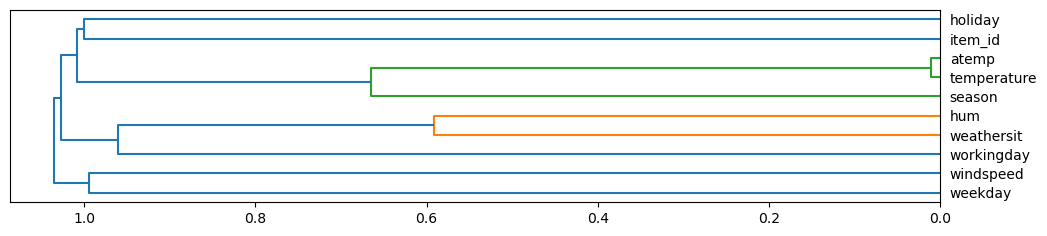

In [68]:
import autogluon.eda.auto as auto

auto.dataset_overview(train_data=train_df,test_data=test_df, label='demand')

In [70]:
train_df

,timestamp,item_id,demand,season,holiday,weekday,workingday,weathersit,temperature,atemp,hum,windspeed
0,2011-01-01 00:00:00,casual,3.0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000
1,2011-01-01 00:00:00,casual,3.0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000
2,2011-01-01 00:00:00,casual,3.0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000
3,2011-01-01 00:00:00,casual,3.0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000
4,2011-01-01 00:00:00,casual,3.0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
268795,2012-11-30 23:00:00,registered,99.0,4.0,0.0,5.0,1.0,2.0,0.30,0.3182,0.75,0.0896
268796,2012-11-30 23:00:00,registered,99.0,4.0,0.0,5.0,1.0,2.0,0.30,0.3182,0.75,0.0896
268797,2012-11-30 23:00:00,registered,99.0,4.0,0.0,5.0,1.0,2.0,0.30,0.3182,0.75,0.0896
268798,2012-11-30 23:00:00,registered,99.0,4.0,0.0,5.0,1.0,2.0,0.30,0.3182,0.75,0.0896


In [95]:
train_data = train_df.drop(columns='timestamp')
test_data = test_df.drop(columns='timestamp')

Features with low p-value appear confidently useful to the predictor, while the other features may be useless to the predictor (or even harmful to include in its training data). A p-value of 0.01 indicates that there is a 1% chance that the feature is useless or harmful, and a 99% chance that the feature is useful. A p-value of 0.99 indicates that there is a 99% chance that the feature is useless or harmful, and a 1% chance that the feature is useful.

- ‘p99_high’: Upper end of 99% confidence interval for true feature importance score. 
- ‘p99_low’: Lower end of 99% confidence interval for true feature importance score.

We detected a substantial difference between the training and test X distributions,
a type of distribution shift.

**Test results**: We can predict whether a sample is in the test vs. training set with a `roc_auc` of
`0.9998` with a p-value of `0.0010` (smaller than the threshold of `0.0100)`.



**Feature importances**: The variables that are the most responsible for this shift are those with high feature importance:



,importance,stddev,p_value,n,p99_high,p99_low
temperature,0.130437,0.010563,0.000005,5,0.152187,0.108687
hum,0.098508,0.007018,0.000003,5,0.112957,0.084059
season,0.085197,0.008447,0.000011,5,0.102590,0.067803
weekday,0.083752,0.009915,0.000023,5,0.104166,0.063337
atemp,0.076161,0.008792,0.000021,5,0.094265,0.058057
windspeed,0.043928,0.002963,0.000002,5,0.050028,0.037827
workingday,0.039458,0.006816,0.000103,5,0.053492,0.025423
weathersit,0.019057,0.003846,0.000189,5,0.026977,0.011138
holiday,0.001279,0.000523,0.002710,5,0.002356,0.000203


**`temperature` values distribution between datasets; p-value: `0.0000`**

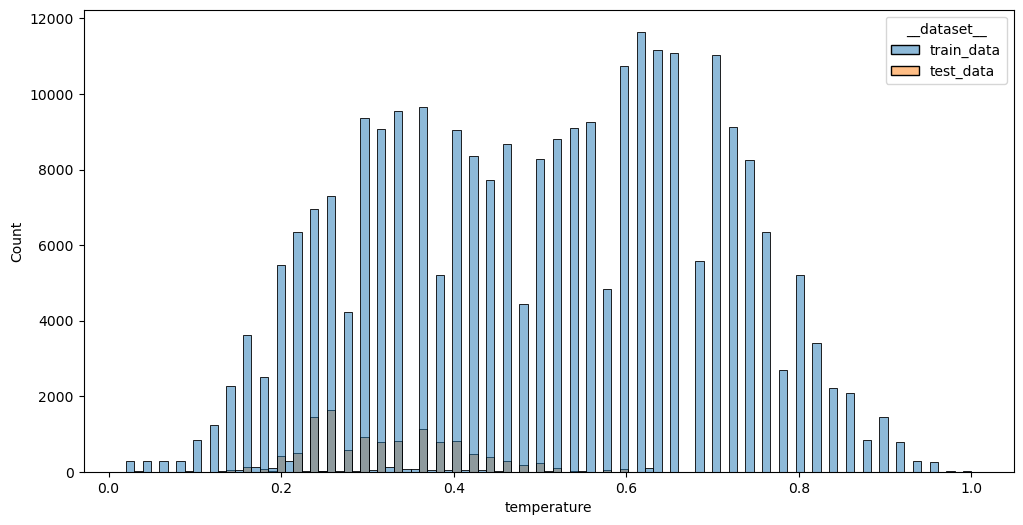

**`hum` values distribution between datasets; p-value: `0.0000`**

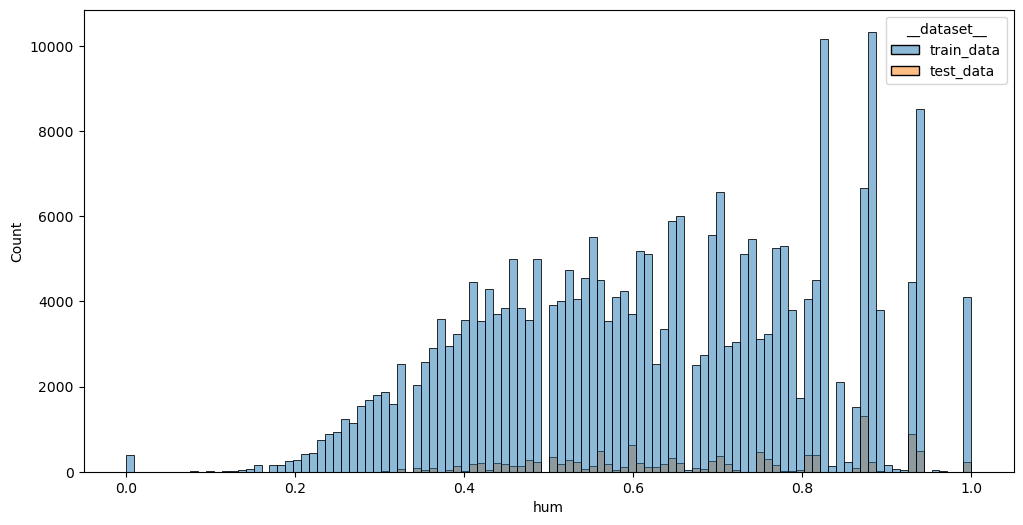

**`season` values distribution between datasets; p-value: `0.0000`**

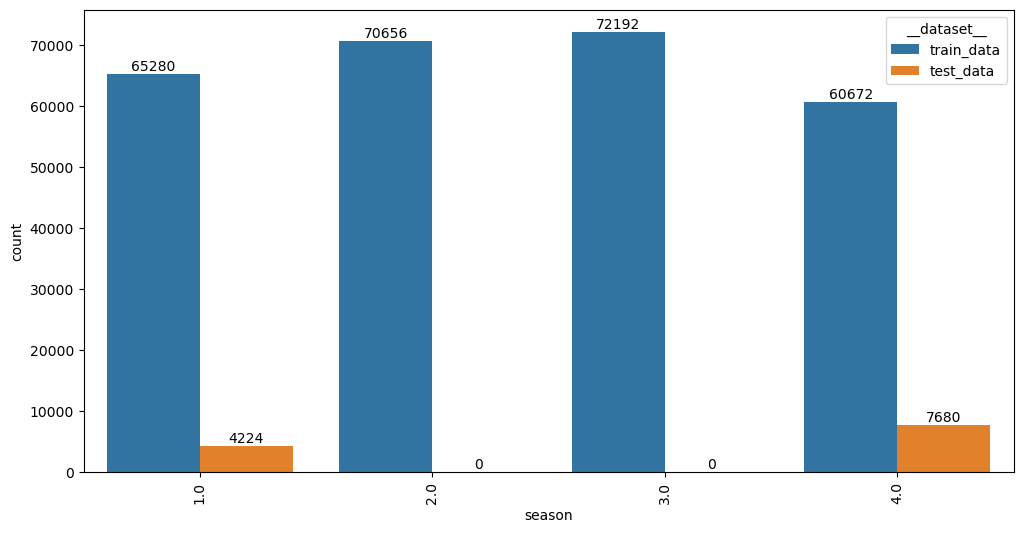

**`weekday` values distribution between datasets; p-value: `0.0000`**

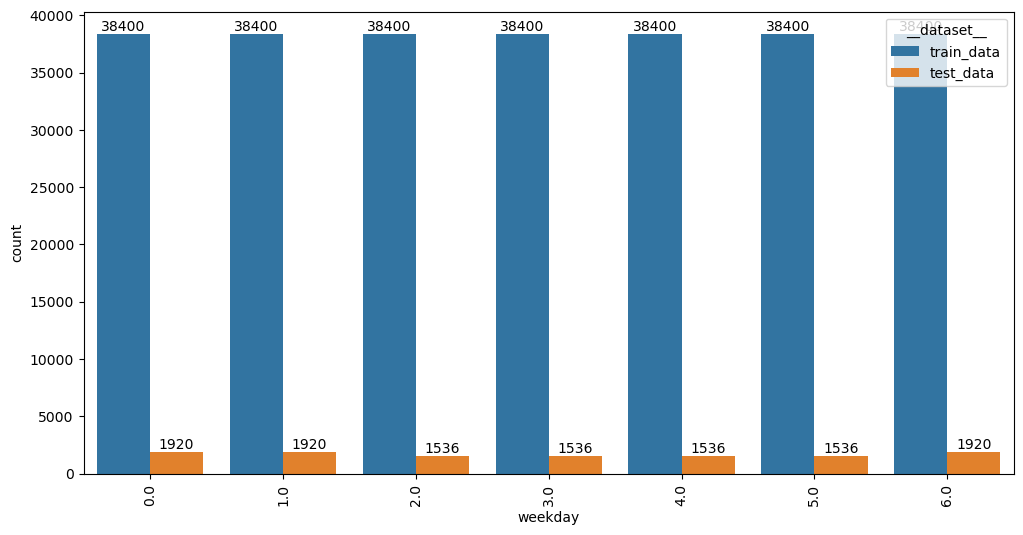

**`atemp` values distribution between datasets; p-value: `0.0000`**

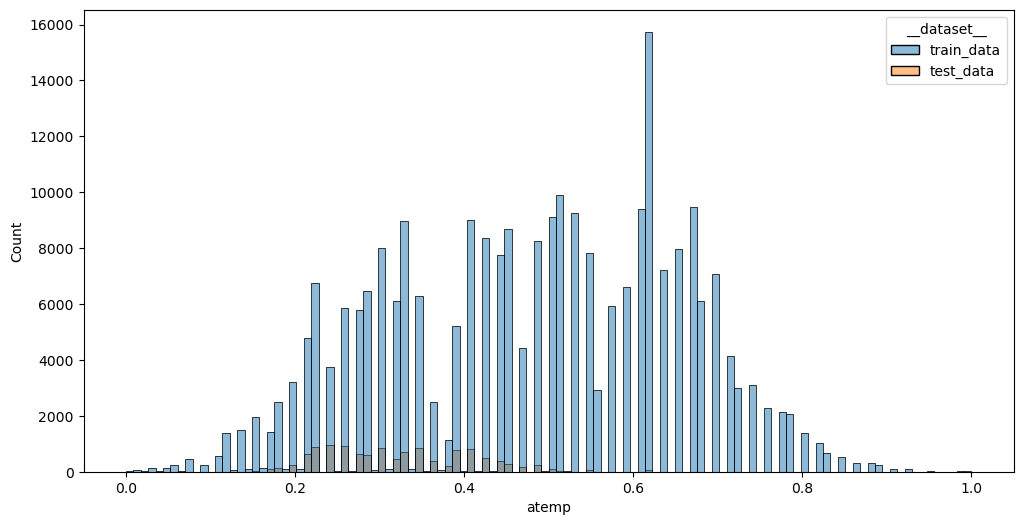

**`windspeed` values distribution between datasets; p-value: `0.0000`**

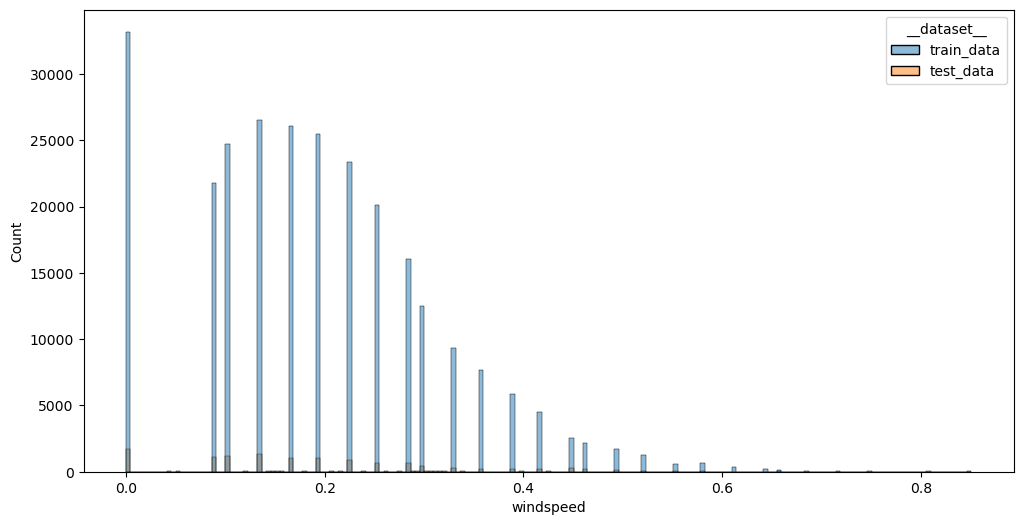

**`workingday` values distribution between datasets; p-value: `0.0001`**

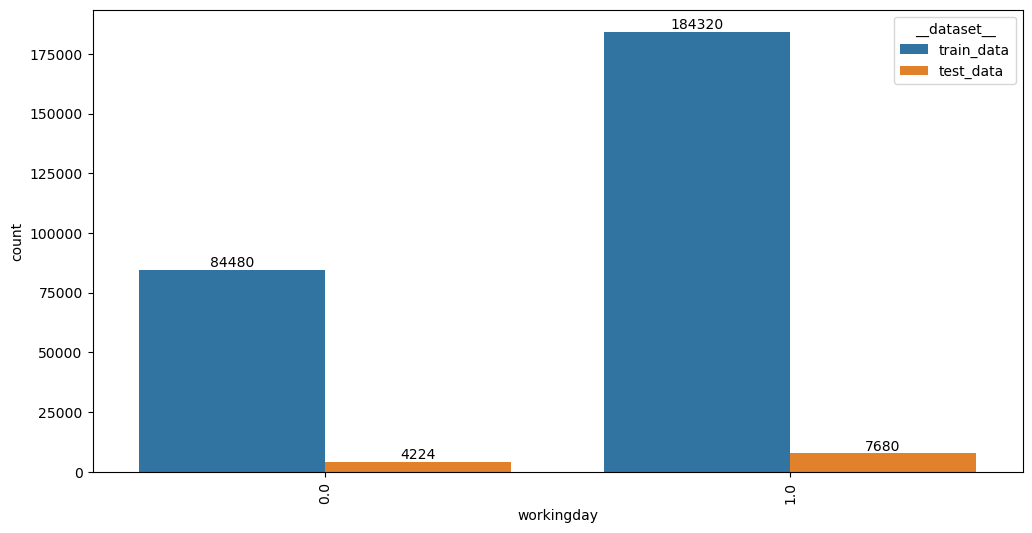

**`weathersit` values distribution between datasets; p-value: `0.0002`**

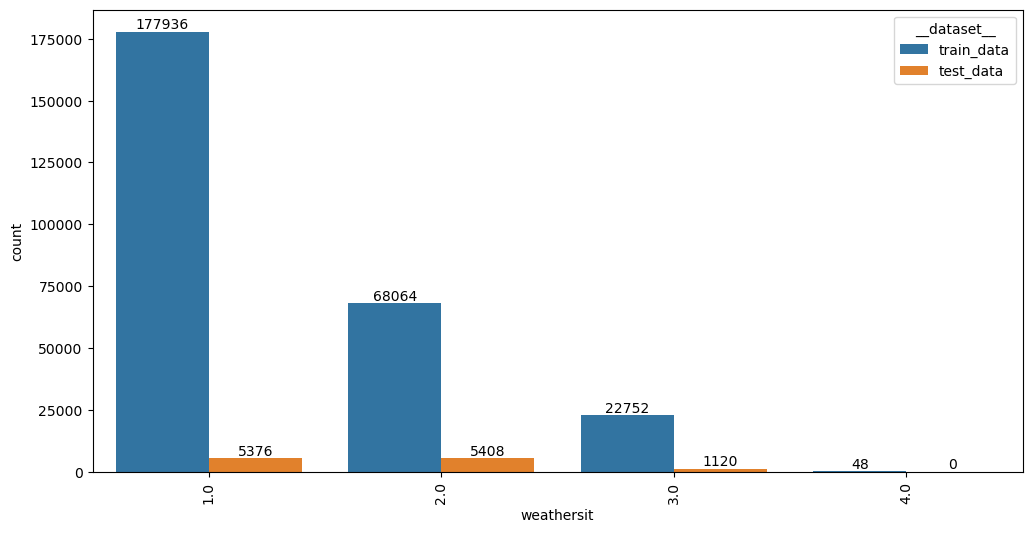

**`holiday` values distribution between datasets; p-value: `0.0027`**

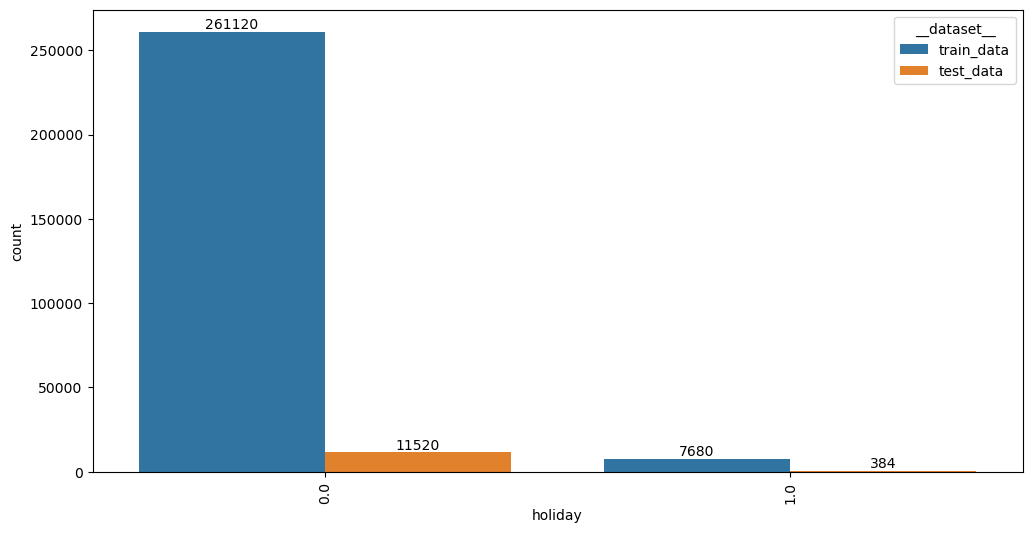

In [96]:
auto.covariate_shift_detection(train_data=train_data, test_data=test_data, label='demand')

모든 데이터셋은 S3로 업로드를 했으며, 모델의 학습을 수행한 다음 성능 비교가 가능합니다.! 실제 Forecast를 수행하기 위해 다음 notebook으로 이동해주시기 바랍니다. 


[2a Amazon Forecast Model](2a_Amazon_Forecast_Model.ipynb)